### Setting up Colab and Github 

In [ ]:
import os 

try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/Connectome Projekt/Connectome')
    train_path = '/content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/data/delcode/train.csv'
    test_path = '/content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/data/delcode/test.csv'
    IN_COLAB = True
except:
    os.chdir(r'C:\Users\leosc\OneDrive\Desktop\WiSe 21-22\Innolab\Connectome Projekt\Connectome')
    train_path = r'C:\Users\leosc\OneDrive\Desktop\WiSe 21-22\Innolab\data\delcode\train.csv'
    test_path = r'C:\Users\leosc\OneDrive\Desktop\WiSe 21-22\Innolab\data\delcode\test.csv'
    IN_COLAB = False

!pip install .

Mounted at /content/drive


### Importing Libraries

In [ ]:
!pip install interpret
!pip install bctpy

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb 
from interpret.glassbox import ExplainableBoostingRegressor, ExplainableBoostingClassifier
from interpret import show


from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, roc_auc_score, plot_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import scipy.stats

import bct
import src.preprocessing.data_loader as dtl
from src.preprocessing.graph_metrics import get_graph_metrics, explain_graph_metrics
from math import sqrt
from datetime import date


plt.style.use("ggplot")
%matplotlib inline



### Loading and Transforming Data

In [ ]:
%%time
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

Input path to train dataset (with name + .csv): /content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/Test/train.csv
Input path to test dataset (with name + .csv): /content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/Test/test.csv
CPU times: user 25.9 s, sys: 1.35 s, total: 27.2 s
Wall time: 43.9 s


In [ ]:
y, X = dtl.preprocess_data(train)
X = X.drop(columns = ['MEM_score', 'Apoe'], inplace = False)
y_test, X_test = dtl.preprocess_data(test)
X_test = X_test.drop(columns = ['MEM_score', 'Apoe'], inplace = False)

In [ ]:
#getting the connectivity matrices and computing the graph metrics
conn_train = [dtl.flat_to_mat(X.iloc[i,3:]) for i in range(len(X))]
conn_test = [dtl.flat_to_mat(X_test.iloc[i,3:]) for i in range(len(X_test))]
graph_train = get_graph_metrics(conn_train)
graph_test = get_graph_metrics(conn_test)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/content/drive/Othercomputers/Mein Laptop/WiSe 21-22/Innolab/Connectome Projekt/Connectome/src/preprocessing/graph_metrics.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  graph_comp = np.array(bct.get_components(adj))


In [ ]:
graph_train_df = graph_train[0]
graph_test_df = graph_test[0]

In [ ]:
graph_train_df = pd.concat([graph_train_df.reset_index(drop=True), X.reset_index(drop=True)], axis=1)
graph_test_df = pd.concat([graph_test_df.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)

In [ ]:
graph_train_df["target"] = y
graph_test_df["target"] = y_test
graph_train_df.to_csv("delcode_train_w_gms.csv")
graph_test_df.to_csv("delcode_test_w_gms.csv")

files.download("delcode_train_w_gms.csv")
files.download("delcode_test_w_gms.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def get_duplicates(l: list) -> list:

    duplicates = []
    lookup = {}
    for i in list(l):
        if i in lookup.keys():
            #print(i)
            duplicates.append(i)
        else:
            lookup[i] = "duplicated"

    return duplicates

get_duplicates(graph_train_df.columns)

[]


### Baseline Model (XGB Untuned Classifier)

In [ ]:
%%time
xgb_baseline = xgb.XGBClassifier()
xgb_baseline.fit(graph_train_df,y)


CPU times: user 1min 13s, sys: 148 ms, total: 1min 13s
Wall time: 1min 13s


In [ ]:
%%time
lgb_baseline = lgb.LGBMClassifier(objective="binary")
lgb_baseline.fit(graph_train_df, y)

CPU times: user 1min 41s, sys: 1.55 s, total: 1min 43s
Wall time: 1min 43s


In [ ]:
lgb_baseline.get_params()

In [ ]:
%%time
ebm = ExplainableBoostingClassifier()
ebm.fit(graph_train_df, y)

CPU times: user 7min 29s, sys: 1.77 s, total: 7min 31s
Wall time: 7min 40s


ExplainableBoostingClassifier(feature_names=['degree_1', 'degree_2', 'degree_3',
                                             'degree_4', 'degree_5', 'degree_6',
                                             'degree_7', 'degree_8', 'degree_9',
                                             'degree_10', 'degree_11',
                                             'degree_12', 'degree_13',
                                             'degree_14', 'degree_15',
                                             'degree_16', 'degree_17',
                                             'degree_18', 'degree_19',
                                             'degree_20', 'degree_21',
                                             'degree_22', 'degree_23',
                                             'degree_24', 'degree_25',
                                             'degree_26', 'd...
                                             'continuous', 'continuous',
                                             'contin

In [ ]:
show(ebm.explain_global())

Text(0, 0.5, 'Feature Importance Score')

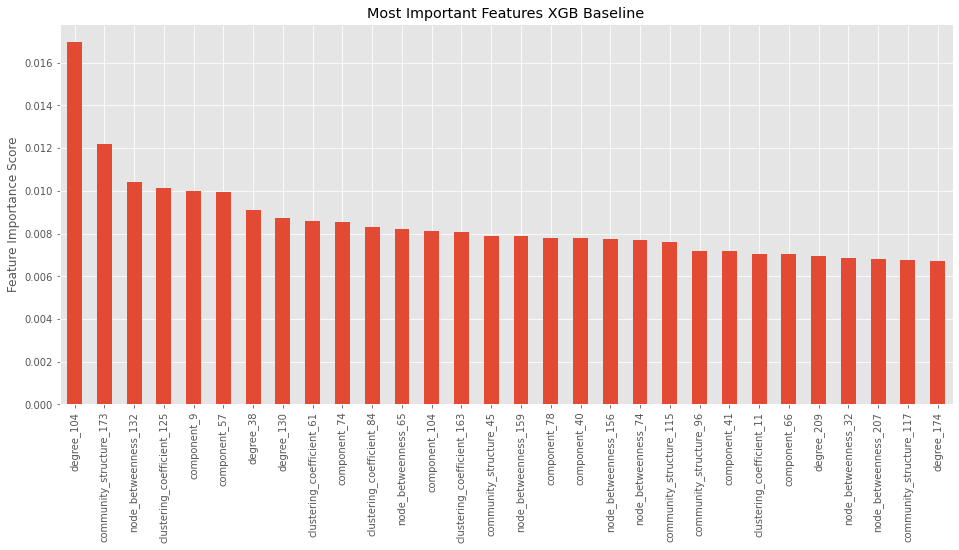

In [ ]:
features = list(graph_train_df.columns)
feat_imp = pd.Series(xgb_baseline.feature_importances_, features).sort_values(ascending=False)
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(7)
feat_imp[0:30].plot(kind='bar', title='Most Important Features XGB Baseline')
plt.ylabel('Feature Importance Score')


In [ ]:
print('Accuracy of the GBM on test set: {:.3f}'.format(xgb_baseline.score(graph_test_df, y_test)), "\n")
pred = xgb_baseline.predict(graph_test_df)
print("Classification Report - XGB Baseline [Test]")
print(classification_report(y_test, pred))

Accuracy of the GBM on test set: 0.765 

Classification Report - XGB Baseline [Test]
              precision    recall  f1-score   support

         0.0       0.74      0.70      0.72        37
         1.0       0.78      0.81      0.80        48

    accuracy                           0.76        85
   macro avg       0.76      0.76      0.76        85
weighted avg       0.76      0.76      0.76        85



In [ ]:
print('Accuracy of the GBM on test set: {:.3f}'.format(lgb_baseline.score(graph_test_df, y_test)), "\n")
pred = lgb_baseline.predict(graph_test_df)
print("Classification Report - LGB Baseline [Test]")
print(classification_report(y_test, pred))

Accuracy of the GBM on test set: 0.788 

Classification Report - LGB Baseline [Test]
              precision    recall  f1-score   support

         0.0       0.79      0.70      0.74        37
         1.0       0.79      0.85      0.82        48

    accuracy                           0.79        85
   macro avg       0.79      0.78      0.78        85
weighted avg       0.79      0.79      0.79        85



In [ ]:
print('Accuracy of the EBM on test set: {:.3f}'.format(ebm.score(graph_test_df, y_test)), "\n")
pred = ebm.predict(graph_test_df)
print("Classification Report - EBM Baseline [Test]")
print(classification_report(y_test, pred))

Accuracy of the EBM on test set: 0.612 

Classification Report - EBM Baseline [Test]
              precision    recall  f1-score   support

         0.0       0.55      0.57      0.56        37
         1.0       0.66      0.65      0.65        48

    accuracy                           0.61        85
   macro avg       0.61      0.61      0.61        85
weighted avg       0.61      0.61      0.61        85



## HPO Libraries

In [ ]:
!pip install flaml

     |████████████████████████████████| 142 kB 5.1 MB/s 
     |████████████████████████████████| 2.0 MB 47.2 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [ ]:
%%time
from flaml import AutoML

automl_settings = {
    "time_budget": 600,  # in seconds
    "metric": 'accuracy',
    "task": 'classification',
    "log_file_name": "flaml_lgb.log",
    "estimator_list": ["lgbm"],#, "xgboost"],
    "eval_method": "cv",
    "n_splits": 5,
    #"split_ratio": 0.2, #either n_splits or split_ratio should be given 
    #"hpo_method": hpo_method, #?? bayesian opt somehow possible?
    "n_jobs": -1, #use all available cpu cores
    #"max_iter": 5,
    "ensemble": True, #whether to perform ensembling after search
    #When ensemble=True, you can directly use automl.predict 
    #or automl.predict_proba to apply the ensemble model. To extract the ensemble model, use automl.model.

}
automl = AutoML(**automl_settings)


CPU times: user 45 µs, sys: 0 ns, total: 45 µs
Wall time: 49.1 µs


In [ ]:
automl.get_params()

{'append_log': False,
 'auto_augment': True,
 'early_stop': False,
 'ensemble': True,
 'estimator_list': ['lgbm'],
 'eval_method': 'cv',
 'hpo_method': 'auto',
 'keep_search_state': False,
 'learner_selector': 'sample',
 'log_file_name': 'flaml_lgb.log',
 'log_training_metric': False,
 'log_type': 'better',
 'max_iter': 1000000,
 'mem_thres': 4294967296,
 'metric': 'accuracy',
 'min_sample_size': 10000,
 'model_history': False,
 'n_concurrent_trials': 1,
 'n_jobs': -1,
 'n_splits': 5,
 'pred_time_limit': inf,
 'retrain_full': True,
 'sample': True,
 'split_ratio': 0.1,
 'split_type': 'auto',
 'starting_points': {},
 'task': 'classification',
 'time_budget': 600,
 'train_time_limit': inf,
 'use_ray': False,
 'verbose': 3}

In [ ]:
fit = automl.fit(graph_train_df, y)

#adjust the search space!
#https://www.kaggle.com/suryajrrafl/lightgbm-tuning-hyperopt-flaml
#https://microsoft.github.io/FLAML/docs/Getting-Started/
#https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML
#https://microsoft.github.io/FLAML/docs/reference/automl/
#data compression via pca or autoencoder https://blog.keras.io/building-autoencoders-in-keras.html

In [ ]:
#print(f"Accuracy of the FLAML lightgbm on test set: {automl.score(graph_test_df, y_test):.3f}", "\n")
pred = automl.predict(graph_test_df)
print("Classification Report - automl Baseline [Test]")
print(classification_report(y_test, pred))

Classification Report - automl Baseline [Test]
              precision    recall  f1-score   support

         0.0       0.68      0.51      0.58        37
         1.0       0.68      0.81      0.74        48

    accuracy                           0.68        85
   macro avg       0.68      0.66      0.66        85
weighted avg       0.68      0.68      0.67        85



In [ ]:
print('Best hyperparmeter config:', automl.best_config)
print(f'Training duration of best run: {automl.best_config_train_time:.4g} s')
print(automl.model.estimator)

Best hyperparmeter config: {'n_estimators': 8, 'num_leaves': 4, 'min_child_samples': 12, 'learning_rate': 0.2677050123105203, 'log_max_bin': 7, 'colsample_bytree': 0.930646190497405, 'reg_alpha': 0.0013483649345371346, 'reg_lambda': 1.4442580148221913}
Training duration of best run: 12.22 s
LGBMClassifier(colsample_bytree=0.930646190497405,
               learning_rate=0.2677050123105203, max_bin=127,
               min_child_samples=12, n_estimators=8, num_leaves=4,
               reg_alpha=0.0013483649345371346, reg_lambda=1.4442580148221913,
               verbose=-1)


In [ ]:
%%time
configs = automl.best_config
configs["n_estimators"] = 200

lgb_refit = lgb.LGBMClassifier(objective="binary", **configs)
lgb_refit.fit(graph_train_df, y)


[LightGBM] [Warning] Unknown parameter: log_max_bin
CPU times: user 1min 20s, sys: 125 ms, total: 1min 20s
Wall time: 1min 20s


In [ ]:
lgb_refit.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.930646190497405,
 'importance_type': 'split',
 'learning_rate': 0.2677050123105203,
 'log_max_bin': 7,
 'max_depth': -1,
 'min_child_samples': 12,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_leaves': 4,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0013483649345371346,
 'reg_lambda': 1.4442580148221913,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [ ]:
print('Accuracy of the GBM on test set: {:.3f}'.format(lgb_refit.score(graph_test_df, y_test)), "\n")
pred = lgb_refit.predict(graph_test_df)
print("Classification Report - LGB Tuned [Test]")
print(classification_report(y_test, pred))

Accuracy of the GBM on test set: 0.765 

Classification Report - LGB Tuned [Test]
              precision    recall  f1-score   support

         0.0       0.74      0.70      0.72        37
         1.0       0.78      0.81      0.80        48

    accuracy                           0.76        85
   macro avg       0.76      0.76      0.76        85
weighted avg       0.76      0.76      0.76        85



In [ ]:
#https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#for-better-accuracy
#https://github.com/microsoft/FLAML
#https://www.kdnuggets.com/2021/03/bayesian-hyperparameter-optimization-tune-sklearn-pycaret.html
#https://docs.ray.io/en/latest/tune/api_docs/suggestion.html
#https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258
#https://github.com/optuna/optuna-examples/blob/main/lightgbm/lightgbm_integration.py
#https://microsoft.github.io/FLAML/docs/Examples/AutoML-for-LightGBM/

### Adjusting Search Space

In [ ]:
from flaml.model import LGBMEstimator
# SKLearnEstimator is derived from BaseEstimator
import rgf

class MyRegularizedGreedyForest(SKLearnEstimator):
    def __init__(self, task="binary", **config):
        super().__init__(task, **config)

        if task in CLASSIFICATION:
            from rgf.sklearn import RGFClassifier

            self.estimator_class = RGFClassifier
        else:
            from rgf.sklearn import RGFRegressor

            self.estimator_class = RGFRegressor

    @classmethod
    def search_space(cls, data_size, task):
        space = {
            "max_leaf": {
                "domain": tune.lograndint(lower=4, upper=data_size),
                "low_cost_init_value": 4,
            },
            "n_iter": {
                "domain": tune.lograndint(lower=1, upper=data_size),
                "low_cost_init_value": 1,
            },
            "learning_rate": {"domain": tune.loguniform(lower=0.01, upper=20.0)},
            "min_samples_leaf": {
                "domain": tune.lograndint(lower=1, upper=20),
                "init_value": 20,
            },
        }
        return space

### Tune class example

In [ ]:
# FLAML tune example
!pip install flaml
from flaml import tune
from flaml.model import LGBMEstimator
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error

X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)


def train_lgbm(config: dict) -> dict:
    # convert config dict to lgbm params
    params = LGBMEstimator(**config).params
    # train the model
    train_set = lightgbm.Dataset(X_train, y_train)
    model = lightgbm.train(params, train_set)
    # evaluate the model
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    # return eval results as a dictionary
    return {"mse": mse}


# load a built-in search space from flaml
flaml_lgbm_search_space = LGBMEstimator.search_space(X_train.shape)
# specify the search space as a dict from hp name to domain; you can define your own search space same way
config_search_space = {
    hp: space["domain"] for hp, space in flaml_lgbm_search_space.items()
}
# give guidance about hp values corresponding to low training cost, i.e., {"n_estimators": 4, "num_leaves": 4}
low_cost_partial_config = {
    hp: space["low_cost_init_value"]
    for hp, space in flaml_lgbm_search_space.items()
    if "low_cost_init_value" in space
}
# initial points to evaluate
points_to_evaluate = [
    {
        hp: space["init_value"]
        for hp, space in flaml_lgbm_search_space.items()
        if "init_value" in space
    }
]
# run the tuning, minimizing mse, with total time budget 3 seconds
analysis = tune.run(
    train_lgbm,
    metric="mse",
    mode="min",
    config=config_search_space,
    low_cost_partial_config=low_cost_partial_config,
    points_to_evaluate=points_to_evaluate,
    time_budget_s=3,
    num_samples=1,
)

TypeError: ignored

In [ ]:
int_tune = config_search_space['n_estimators']
int_tune.sample()

87

In [ ]:
#https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.OptunaSearchCV.html

"""
Optuna example that demonstrates a pruner for LightGBM.
In this example, we optimize the validation accuracy of cancer detection using LightGBM.
We optimize both the choice of booster model and their hyperparameters. Throughout
training of models, a pruner observes intermediate results and stop unpromising trials.
You can run this example as follows:
    $ python lightgbm_integration.py
"""
#!pip install optuna
import numpy as np
import optuna

import lightgbm as lgb
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split


# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
    train_x, valid_x, train_y, valid_y = train_test_split(graph_train_df, y, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)
    dvalid = lgb.Dataset(valid_x, label=valid_y)

    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")
    gbm = lgb.train(param, dtrain, valid_sets=[dvalid], callbacks=[pruning_callback])

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="maximize"
    )
    study.optimize(objective, n_trials=1000)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-01-26 17:10:10,740] A new study created in memory with name: no-name-f13e9339-8c38-4f9c-ad38-3e2dd68cf757
[I 2022-01-26 17:10:11,481] Trial 0 finished with value: 0.6185567010309279 and parameters: {'lambda_l1': 0.0014973874919618818, 'lambda_l2': 0.000219971706573216, 'num_leaves': 240, 'feature_fraction': 0.9263319941667951, 'bagging_fraction': 0.8349936009887726, 'bagging_freq': 4, 'min_child_samples': 46}. Best is trial 0 with value: 0.6185567010309279.
[I 2022-01-26 17:10:12,125] Trial 1 finished with value: 0.5979381443298969 and parameters: {'lambda_l1': 2.492640370981115e-06, 'lambda_l2': 0.009606935586844043, 'num_leaves': 122, 'feature_fraction': 0.6958541862456737, 'bagging_fraction': 0.7666332389575152, 'bagging_freq': 2, 'min_child_samples': 52}. Best is trial 0 with value: 0.6185567010309279.
[I 2022-01-26 17:10:12,858] Trial 2 finished with value: 0.5567010309278351 and parameters: {'lambda_l1': 5.517485033602278, 'lambda_l2': 3.7523558507062824e-08, 'num_leaves'

Number of finished trials: 1000
Best trial:
  Value: 0.7525773195876289
  Params: 
    lambda_l1: 0.9630291790569299
    lambda_l2: 9.218319425355277
    num_leaves: 53
    feature_fraction: 0.8145669552761242
    bagging_fraction: 0.7352775607466393
    bagging_freq: 1
    min_child_samples: 80


In [ ]:
#idea to ajdust to cv 

def objective(trial, train_loader, valid_loader):

    # Remove the following line.
    # train_loader, valid_loader = get_mnist()

    ...

    return accuracy


def objective_cv(trial):

    # Get the MNIST dataset.
    dataset = datasets.MNIST(DIR, train=True, download=True, transform=transforms.ToTensor())

    fold = KFold(n_splits=3, shuffle=True, random_state=0)
    scores = []
    for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(range(len(dataset)))):
        train_data = torch.utils.data.Subset(dataset, train_idx)
        valid_data = torch.utils.data.Subset(dataset, valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_data,
            batch_size=BATCHSIZE,
            shuffle=True,
        )
        valid_loader = torch.utils.data.DataLoader(
            valid_data,
            batch_size=BATCHSIZE,
            shuffle=True,
        )

        accuracy = objective(trial, train_loader, valid_loader)
        scores.append(accuracy)
    return np.mean(scores)


study = optuna.create_study(direction="maximize")
study.optimize(objective_cv, n_trials=20, timeout=600)

In [ ]:
optuna_lgb = lgb.LGBMClassifier(**study.best_trial.params)
optuna_lgb.fit(graph_train_df, y)

[LightGBM] [Warning] lambda_l1 is set=0.9630291790569299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9630291790569299
[LightGBM] [Warning] bagging_fraction is set=0.7352775607466393, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7352775607466393
[LightGBM] [Warning] feature_fraction is set=0.8145669552761242, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8145669552761242
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=9.218319425355277, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.218319425355277


LGBMClassifier(bagging_fraction=0.7352775607466393, bagging_freq=1,
               feature_fraction=0.8145669552761242,
               lambda_l1=0.9630291790569299, lambda_l2=9.218319425355277,
               min_child_samples=80, num_leaves=53)

In [ ]:
pred = optuna_lgb.predict(graph_test_df)
print("Classification Report - optuna Baseline [Test]")
print(classification_report(y_test, pred))

Classification Report - optuna Baseline [Test]
              precision    recall  f1-score   support

         0.0       0.48      0.41      0.44        37
         1.0       0.59      0.67      0.63        48

    accuracy                           0.55        85
   macro avg       0.54      0.54      0.53        85
weighted avg       0.55      0.55      0.55        85



### Optuna CV

In [ ]:
import optuna
from sklearn.datasets import load_iris
from sklearn.svm import SVC

clf = SVC(gamma="auto")
param_distributions = {"C": optuna.distributions.LogUniformDistribution(1e-10, 1e10)}
optuna_search = optuna.integration.OptunaSearchCV(clf, param_distributions)
X, y = load_iris(return_X_y=True)
optuna_search.fit(X, y)
y_pred = optuna_search.predict(X)

### Bayesian Optimization + CV

In [ ]:
#https://towardsdatascience.com/seeing-numbers-bayesian-optimisation-of-a-lightgbm-model-3642228127b3